## Requirements

Before starting this tutorial, ensure that you have the following installed:

* Qiskit SDK 1.0 or later, with visualization support (`pip install 'qiskit[visualization]'`)
* Qiskit Runtime (`pip install qiskit-ibm-runtime`) 0.22 or later
* SciPy (`python -m pip install scipy`)


In [1]:

import numpy as np
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import Aer
try:
    backend = Aer.get_backend('aer_simulator_statevector_gpu')
    backend.set_options(device='GPU')
    backend.set_options(cuStateVec_enable=False)
    print("GPU options set successfully." , backend)
except Exception as e:
    print(f"Failed to set GPU options: {e}")
 


GPU options set successfully. AerSimulator('aer_simulator_statevector_gpu')


In [3]:
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.drivers import PySCFDriver

molecule = MoleculeInfo(
        # Coordinates in Angstrom
        symbols=["H", "H"],
        coords=([0.0, 0.0, 0.0], [1.6895640, 0.0, 0.0]),
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )


driver = PySCFDriver.from_molecule(molecule)
properties = driver.run()

problem = FreezeCoreTransformer(
    freeze_core=True, 
).transform(properties)

num_particles = problem.num_particles
num_spatial_orbitals = problem.num_spatial_orbitals

mapper = ParityMapper(num_particles=num_particles)
hamiltonian = mapper.map(problem.second_q_ops()[0])
hamiltonian

SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'XX'],
              coeffs=[-0.97846545+0.j,  0.09735879+0.j, -0.09735879+0.j, -0.00287021+0.j,
  0.24143891+0.j])

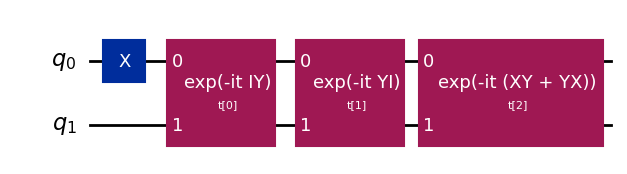

In [4]:
init_state = HartreeFock( num_spatial_orbitals, num_particles, mapper)
var_form = UCCSD( num_spatial_orbitals, num_particles, mapper, initial_state=init_state)
var_form.decompose().draw("mpl", style="iqp")

From the previous figure we see that our ansatz circuit is defined by a vector of parameters, $\theta_{i}$, with the total number given by:


In [5]:

num_params1 = var_form.num_parameters
print(f"using usscd = {num_params1}")

using usscd = 3


## Step 2: Optimize problem for quantum execution


To reduce the total job execution time, Qiskit primitives only accept circuits (ansatz) and observables (Hamiltonian) that conform to the instructions and connectivity supported by the target system (referred to as instruction set architecture (ISA) circuits and observables).


### ISA circuit


Schedule a series of [`qiskit.transpiler`](https://docs.quantum-computing.ibm.com/api/qiskit/transpiler) passes to optimize the circuit for a selected backend and make it compatible with the backend's ISA. This can be easily done with a preset pass manager from `qiskit.transpiler` and its `optimization_level` parameter.

The lowest optimization level does the minimum needed to get the circuit running on the device; it maps the circuit qubits to the device qubits and adds swap gates to allow all two-qubit operations. The highest optimization level is much smarter and uses lots of tricks to reduce the overall gate count. Since multi-qubit gates have high error rates and qubits decohere over time, the shorter circuits should give better results.


In [6]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(var_form)

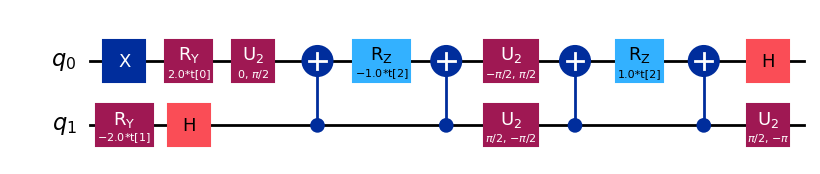

In [7]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

### ISA observable


Transform the Hamiltonian to make it backend-compatible before running jobs with [`Runtime Estimator V2`](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.EstimatorV2#run). Perform the transformation by using the `apply_layout` method of `SparsePauliOp` object.


In [8]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

## Step 3: Execute using Qiskit Primitives

Like many classical optimization problems, the solution to a VQE problem can be formulated as minimization of a scalar cost function.  By definition, VQE looks to find the ground state solution to a Hamiltonian by optimizing the ansatz circuit parameters to minimize the expectation value (energy) of the Hamiltonian.  With the Qiskit Runtime [`Estimator`](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.EstimatorV2) directly taking a Hamiltonian and parameterized ansatz, and returning the necessary energy, the cost function for a VQE instance is quite simple.

Note that the `run()` method of [Qiskit Runtime `EstimatorV2`](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.EstimatorV2)  takes an iterable of `primitive unified blocs (PUBs)`. Each PUB is an iterable in the format `(circuit, observables, parameter_values: Optional, precision: Optional)`.


In [9]:
def cost_func(params, ansatz, hamiltonian, estimator):
 
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [10]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [11]:
x0 =  np.pi * np.random.random(num_params1)

In [12]:
x0

array([2.32836012, 2.66286183, 1.26933572])

In [13]:
trace_data = {
    'parameters': [],
    'energy': []
}



def store_intermediate_result(xk):
    # Here, xk are the current parameters
    energy = cost_func(xk, ansatz_isa, hamiltonian_isa, estimator)  # Compute energy at current parameters
    trace_data['parameters'].append(xk)
    trace_data['energy'].append(energy)
    print(f"Parameters = {xk} ") 
    print(f"Energy = {energy:.5f}")
    print("")

In [14]:
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
        # callback=store_intermediate_result
    )

Iters. done: 1 [Current cost: -0.8387517972685824]
Iters. done: 2 [Current cost: -0.7762810024307736]
Iters. done: 3 [Current cost: -0.9759058785372492]
Iters. done: 4 [Current cost: -1.030113289388744]
Iters. done: 5 [Current cost: -0.7424872945713858]
Iters. done: 6 [Current cost: -1.1104053887876313]
Iters. done: 7 [Current cost: -1.2148416302062572]
Iters. done: 8 [Current cost: -1.2289835877686321]
Iters. done: 9 [Current cost: -1.0978212627226611]
Iters. done: 10 [Current cost: -1.1373042173358352]
Iters. done: 11 [Current cost: -1.2581716991866965]
Iters. done: 12 [Current cost: -1.1083333092083663]
Iters. done: 13 [Current cost: -1.1387351196486513]
Iters. done: 14 [Current cost: -1.216962775093025]
Iters. done: 15 [Current cost: -1.2616674405563315]
Iters. done: 16 [Current cost: -1.212413996757497]
Iters. done: 17 [Current cost: -1.2734874008759602]
Iters. done: 18 [Current cost: -1.2652058974094094]
Iters. done: 19 [Current cost: -1.268616454551911]
Iters. done: 20 [Current 

At the terminus of this routine we have a result in the standard SciPy `OptimizeResult` format.  From this we see that it took `nfev` number of cost function evaluations to obtain the solution vector of parameter angles (`x`) that, when plugged into the ansatz circuit, yield the approximate ground state solution we were looking for.


In [15]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.2808221788862983
       x: [ 3.395e+00  2.865e+00  2.795e+00]
    nfev: 44
   maxcv: 0.0

In [16]:
from qiskit_algorithms import MinimumEigensolverResult

result = MinimumEigensolverResult()
result.eigenvalue = res.fun
interpreted_result = problem.interpret(result)
print(interpreted_result)
 

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.280822178886
  - computed part:      -1.280822178886
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.313203412786
> Total ground state energy (Hartree): -0.967618766101
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [3.19281323  0.0  0.0]
 


In [17]:
all(cost_history_dict["prev_vector"] == res.x)

True

In [18]:
cost_history_dict["iters"] == res.nfev

True

We can also now view the progress toward convergence as monitored by the cost history at each iteration:


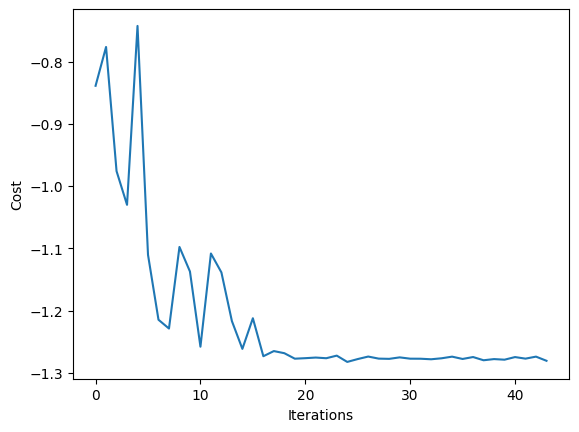

In [19]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [20]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.29.0'

In [21]:
import qiskit

qiskit.version.get_version_info()

'1.1.1'